# Import Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import set_config

set_config(transform_output="pandas")

In [3]:
# load the cleaned data

df = pd.read_csv('cleaned_data.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,time_taken,City_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time,order_hour,order_period,distance
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,Sunny,high,...,24.0,INDO,Saturday,3.0,19.0,1.0,15.0,11.0,Morning,3.025149
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,Stormy,jam,...,33.0,BANG,Friday,3.0,25.0,0.0,5.0,19.0,Evening,20.183530
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,Sandstorms,low,...,26.0,BANG,Saturday,3.0,19.0,1.0,15.0,8.0,Morning,1.552758
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,Sunny,medium,...,21.0,COIMB,Tuesday,4.0,5.0,0.0,10.0,18.0,Evening,7.790401
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,Cloudy,high,...,30.0,CHEN,Saturday,3.0,26.0,1.0,15.0,13.0,Afternoon,6.210138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23645,SURRES05DEL02,32.0,4.5,21.175104,72.804342,21.255104,72.884342,2022-03-08,Sunny,jam,...,20.0,SUR,Tuesday,3.0,8.0,0.0,15.0,21.0,Night,12.161451
23646,VADRES05DEL03,30.0,4.5,22.310526,73.170937,22.340526,73.200937,2022-04-03,Stormy,medium,...,30.0,VAD,Sunday,4.0,3.0,1.0,10.0,17.0,Evening,4.544228
23647,INDORES05DEL01,22.0,4.8,22.727021,75.884167,22.767021,75.924167,2022-03-01,Stormy,high,...,15.0,INDO,Tuesday,3.0,1.0,0.0,15.0,13.0,Afternoon,6.050462
23648,VADRES04DEL03,22.0,4.7,NaN,NaN,NaN,NaN,2022-03-28,Fog,low,...,19.0,VAD,Monday,3.0,28.0,0.0,5.0,23.0,Night,NaN


In [4]:
df['distance_type'] = pd.cut(df['distance'],bins=[0,5,10,15,25],
                             right=False,labels=['short','medium','long','very_long'])

In [5]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'City_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time', 'order_hour',
       'order_period', 'distance', 'distance_type'],
      dtype='object')

In [6]:
df.rename(columns={
    'City_name':'city_name',
    'order_hour':'order_time_hour',
    'order_period':'order_time_of_day',


},inplace=True)

In [7]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time,order_time_of_day,distance,distance_type
0,37.0,4.9,Sunny,high,2.0,snack,motorcycle,0.0,No,urban,24.0,1.0,15.0,Morning,3.025149,short
1,34.0,4.5,Stormy,jam,2.0,snack,scooter,1.0,No,metropolitian,33.0,0.0,5.0,Evening,20.183530,very_long
2,23.0,4.4,Sandstorms,low,0.0,drinks,motorcycle,1.0,No,urban,26.0,1.0,15.0,Morning,1.552758,short
3,38.0,4.7,Sunny,medium,0.0,buffet,motorcycle,1.0,No,metropolitian,21.0,0.0,10.0,Evening,7.790401,medium
4,32.0,4.6,Cloudy,high,1.0,snack,scooter,1.0,No,metropolitian,30.0,1.0,15.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23645,32.0,4.5,Sunny,jam,1.0,meal,scooter,0.0,No,metropolitian,20.0,0.0,15.0,Night,12.161451,long
23646,30.0,4.5,Stormy,medium,1.0,snack,motorcycle,1.0,No,metropolitian,30.0,1.0,10.0,Evening,4.544228,short
23647,22.0,4.8,Stormy,high,1.0,snack,scooter,1.0,No,metropolitian,15.0,0.0,15.0,Afternoon,6.050462,medium
23648,22.0,4.7,Fog,low,2.0,buffet,motorcycle,0.0,No,metropolitian,19.0,0.0,5.0,Night,NaN,NaN


In [8]:
# check for missing values

df.isna().sum()

,0
age,912
ratings,945
weather,274
traffic,267
vehicle_condition,1
type_of_order,1
type_of_vehicle,1
multiple_deliveries,492
festival,119
city_type,610


In [9]:
# check for duplicates

df.duplicated().sum()
df.drop_duplicates(inplace=True)

<Axes: >

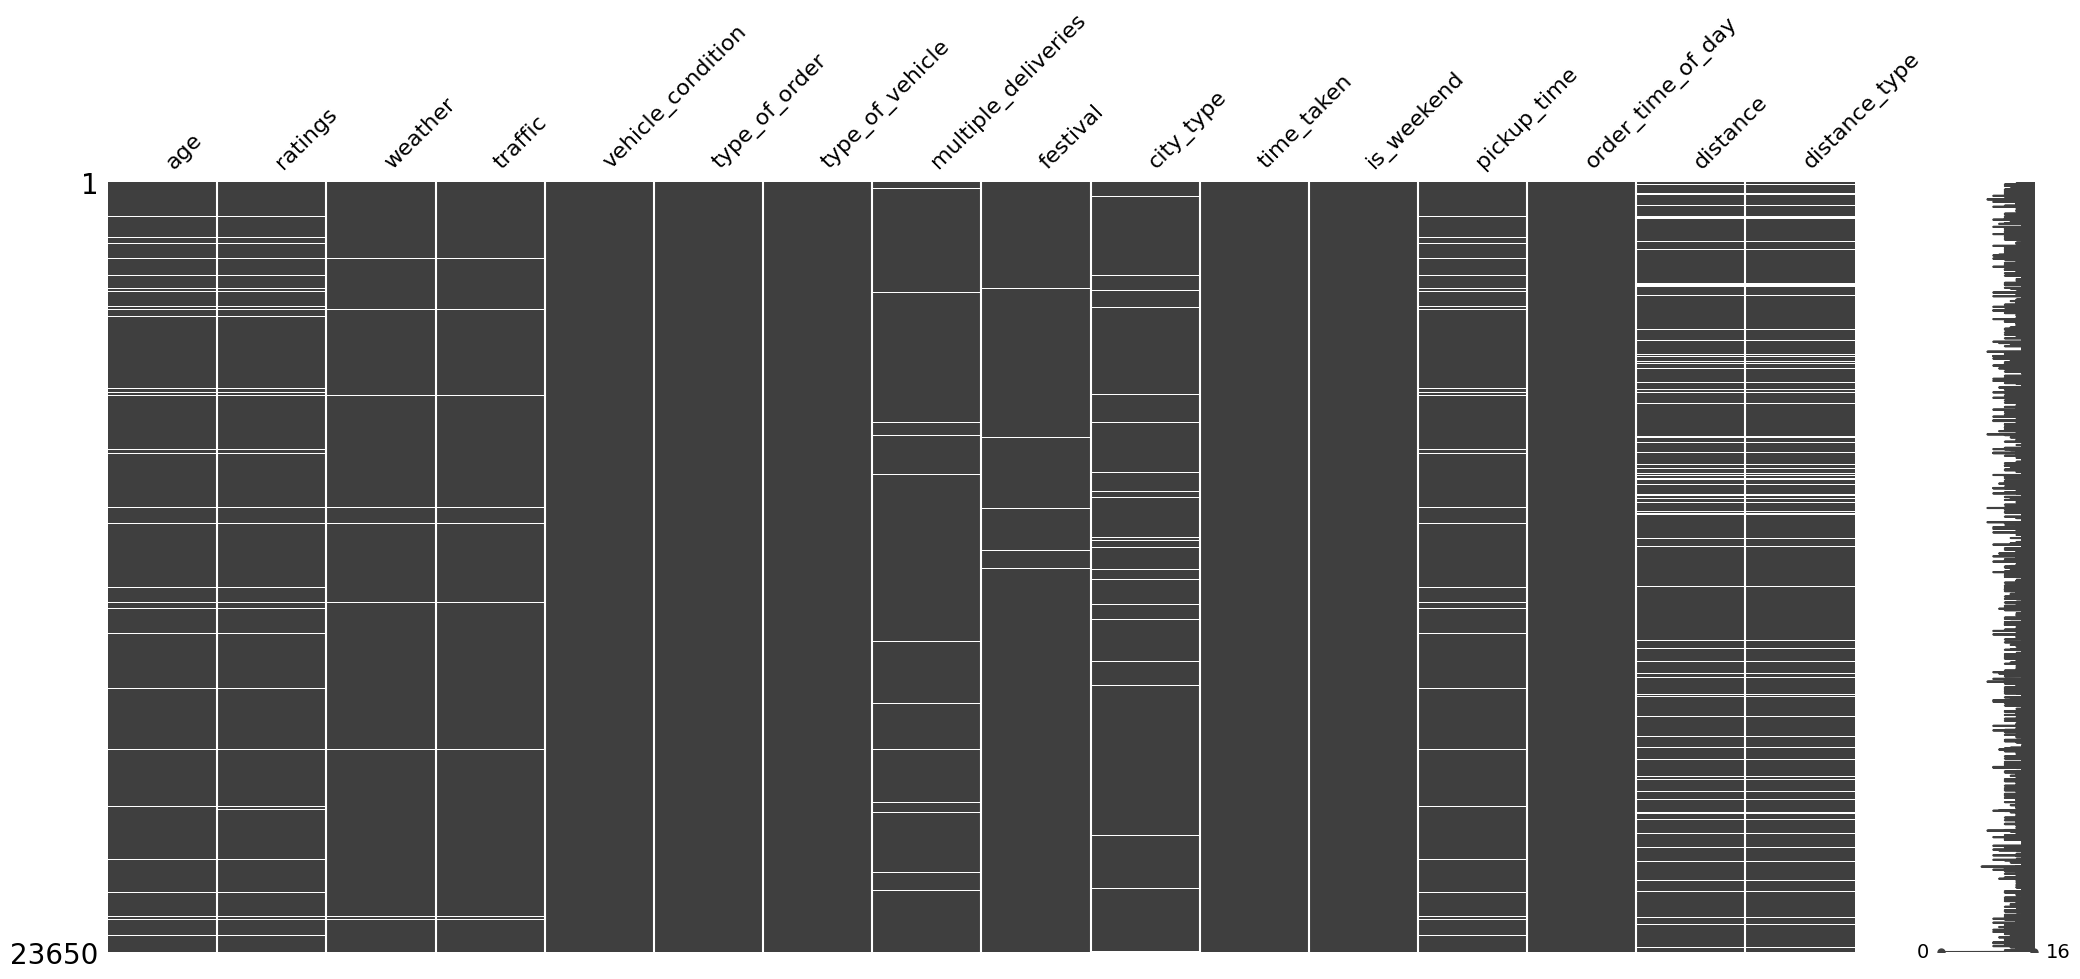

In [10]:
import missingno as msno

msno.matrix(df)

In [11]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [12]:
temp_df = df.copy().dropna()

In [13]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time,order_time_of_day,distance,distance_type
0,37.0,4.9,Sunny,high,2.0,snack,motorcycle,0.0,No,urban,1.0,15.0,Morning,3.025149,short
1,34.0,4.5,Stormy,jam,2.0,snack,scooter,1.0,No,metropolitian,0.0,5.0,Evening,20.183530,very_long
2,23.0,4.4,Sandstorms,low,0.0,drinks,motorcycle,1.0,No,urban,1.0,15.0,Morning,1.552758,short
3,38.0,4.7,Sunny,medium,0.0,buffet,motorcycle,1.0,No,metropolitian,0.0,10.0,Evening,7.790401,medium
4,32.0,4.6,Cloudy,high,1.0,snack,scooter,1.0,No,metropolitian,1.0,15.0,Afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23643,37.0,4.8,Sunny,low,0.0,meal,motorcycle,1.0,No,urban,0.0,10.0,Night,19.882650,very_long
23644,39.0,4.3,Sandstorms,high,2.0,snack,motorcycle,0.0,No,metropolitian,0.0,10.0,Morning,1.552417,short
23645,32.0,4.5,Sunny,jam,1.0,meal,scooter,0.0,No,metropolitian,0.0,15.0,Night,12.161451,long
23646,30.0,4.5,Stormy,medium,1.0,snack,motorcycle,1.0,No,metropolitian,1.0,10.0,Evening,4.544228,short


In [14]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (15848, 15)
The shape of test data is (3962, 15)


In [16]:
# missing values in train data

X_train.isna().sum()

,0
age,0
ratings,0
weather,0
traffic,0
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,0
festival,0
city_type,0


In [17]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [18]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [19]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre Processing Pipeline

In [20]:
num_cols = ["age","ratings","pickup_time","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [21]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [22]:
X_train.isna().sum()

,0
age,0
ratings,0
weather,0
traffic,0
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,0
festival,0
city_type,0


In [ ]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [ ]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [ ]:
# simple_imputer.fit_transform(X_train)

In [ ]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [ ]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [23]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [24]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [25]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['medium' 'low' 'jam' 'high']
distance_type ['medium', 'short', 'very_long', 'long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [26]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time', 'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [27]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time', 'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [28]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [29]:
X_train_trans

,age,ratings,pickup_time,distance,weather_Fog,weather_Sandstorms,weather_Stormy,weather_Sunny,weather_Windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1.0,order_time_of_day_Evening,order_time_of_day_Morning,order_time_of_day_Night,traffic,distance_type,vehicle_condition,multiple_deliveries
22608,0.210526,1.00,1.0,0.238700,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
20844,0.842105,0.88,0.5,0.158741,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
16935,0.736842,0.92,0.5,0.163658,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8847,0.421053,0.96,0.0,0.324304,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3704,0.684211,1.00,1.0,0.003329,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13546,0.210526,0.96,0.5,0.243319,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
14349,0.631579,0.68,1.0,0.764777,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
6512,0.947368,0.92,0.0,0.482063,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0
1040,0.105263,0.92,0.0,0.160557,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0


In [30]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.1 MB/s eta 0:00:00


In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error

In [33]:
def objective(trial):
    model_name = trial.suggest_categorical("model", ["SVM", "RF", "KNN", "GB", "XGB", "LGBM"])

    # Define model based on selection
    if model_name == "SVM":
        kernel_svm = trial.suggest_categorical("kernel_svm", ["linear", "poly", "rbf"])
        if kernel_svm == "linear":
            c_linear = trial.suggest_float("c_linear", 0, 10)
            model = SVR(C=c_linear, kernel="linear")
        elif kernel_svm == "poly":
            c_poly = trial.suggest_float("c_poly", 0, 10)
            degree_poly = trial.suggest_int("degree_poly", 1, 5)
            model = SVR(C=c_poly, degree=degree_poly, kernel="poly")
        else:  # rbf
            c_rbf = trial.suggest_float("c_rbf", 0, 100)
            gamma_rbf = trial.suggest_float("gamma_rbf", 0, 10)
            model = SVR(C=c_rbf, gamma=gamma_rbf, kernel="rbf")

    elif model_name == "RF":
        n_estimators_rf = trial.suggest_int("n_estimators_rf", 10, 200)
        max_depth_rf = trial.suggest_int("max_depth_rf", 2, 20)
        model = RandomForestRegressor(
            n_estimators=n_estimators_rf,
            max_depth=max_depth_rf,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == "GB":
        n_estimators_gb = trial.suggest_int("n_estimators_gb", 10, 200)
        learning_rate_gb = trial.suggest_float("learning_rate_gb", 0, 1)
        max_depth_gb = trial.suggest_int("max_depth_gb", 2, 20)
        model = GradientBoostingRegressor(
            n_estimators=n_estimators_gb,
            learning_rate=learning_rate_gb,
            max_depth=max_depth_gb,
            random_state=42
        )

    elif model_name == "KNN":
        n_neighbors_knn = trial.suggest_int("n_neighbors_knn", 1, 25)
        weights_knn = trial.suggest_categorical("weights_knn", ["uniform", "distance"])
        model = KNeighborsRegressor(
            n_neighbors=n_neighbors_knn,
            weights=weights_knn,
            n_jobs=-1
        )

    elif model_name == "XGB":
        n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 10, 200)
        learning_rate_xgb = trial.suggest_float("learning_rate_xgb", 0.1, 0.5)
        max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 20)
        model = XGBRegressor(
            n_estimators=n_estimators_xgb,
            learning_rate=learning_rate_xgb,
            max_depth=max_depth_xgb,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == "LGBM":
        n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 10, 200)
        learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm", 0.1, 0.5)
        max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 2, 20)
        model = LGBMRegressor(
            n_estimators=n_estimators_lgbm,
            learning_rate=learning_rate_lgbm,
            max_depth=max_depth_lgbm,
            random_state=42,
            n_jobs=-1
        )

    # Fit the model
    model.fit(X_train_trans, y_train_pt.values.ravel())

    # Predict
    y_pred_test = model.predict(X_test_trans)

    # Inverse transform
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # Calculate MAE
    error = mean_absolute_error(y_test, y_pred_test_org)

    return error


In [34]:
# create optuna study
study = optuna.create_study(direction="minimize", study_name="model_selection")

# optimize the objective function
study.optimize(objective, n_trials=30, n_jobs=-1)

# print the best parameters and score
print("Best parameters:", study.best_params)
print("Best MAE:", study.best_value)


[I 2025-07-01 12:44:39,682] A new study created in memory with name: model_selection
[I 2025-07-01 12:44:40,579] Trial 1 finished with value: 4.471095061633984 and parameters: {'model': 'KNN', 'n_neighbors_knn': 21, 'weights_knn': 'uniform'}. Best is trial 1 with value: 4.471095061633984.
[I 2025-07-01 12:44:45,213] Trial 2 finished with value: 3.2227543852551217 and parameters: {'model': 'RF', 'n_estimators_rf': 67, 'max_depth_rf': 10}. Best is trial 2 with value: 3.2227543852551217.
[I 2025-07-01 12:44:48,164] Trial 3 finished with value: 3.021321779769331 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 169, 'learning_rate_lgbm': 0.1342466026204955, 'max_depth_lgbm': 15}. Best is trial 3 with value: 3.021321779769331.
[I 2025-07-01 12:45:05,979] Trial 4 finished with value: 3.0036547889575256 and parameters: {'model': 'GB', 'n_estimators_gb': 169, 'learning_rate_gb': 0.04456683952250301, 'max_depth_gb': 9}. Best is trial 4 with value: 3.0036547889575256.
[I 2025-07-01 12:45:43

Best parameters: {'model': 'GB', 'n_estimators_gb': 169, 'learning_rate_gb': 0.04456683952250301, 'max_depth_gb': 9}
Best MAE: 3.0036547889575256


In [ ]:
lgbm_params = {
    "n_estimators": 145,
    "learning_rate": 0.16632111599858262,
    "max_depth": 17
}

In [ ]:
# train the model on best parameters

lgbm = LGBMRegressor(**lgbm_params)

lgbm.fit(X_train_trans,y_train_pt.values.ravel())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000


LGBMRegressor(learning_rate=0.16632111599858262, max_depth=17, n_estimators=145)

In [ ]:
# get the predictions
y_pred_train = lgbm.predict(X_train_trans)
y_pred_test = lgbm.predict(X_test_trans)

In [ ]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 2.78 minutes
The test error is 3.02 minutes


In [ ]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.86
The test r2 score is 0.84


In [ ]:
# dataframe of results

study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_c_linear,params_c_poly,params_c_rbf,params_degree_poly,params_gamma_rbf,...,params_max_depth_rf,params_max_depth_xgb,params_model,params_n_estimators_gb,params_n_estimators_lgbm,params_n_estimators_rf,params_n_estimators_xgb,params_n_neighbors_knn,params_weights_knn,state
0,0,3.014081,2024-11-29 08:03:58.250867,2024-11-29 08:04:02.374741,0 days 00:00:04.123874,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,122.0,NaN,NaN,NaN,NaN,COMPLETE
1,1,3.069600,2024-11-29 08:03:58.259699,2024-11-29 08:04:04.406489,0 days 00:00:06.146790,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,157.0,NaN,NaN,NaN,NaN,COMPLETE
2,2,4.675431,2024-11-29 08:04:02.384515,2024-11-29 08:09:10.825547,0 days 00:05:08.441032,1.036033,NaN,NaN,NaN,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,3.529718,2024-11-29 08:04:04.415851,2024-11-29 08:04:23.054133,0 days 00:00:18.638282,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,RF,NaN,NaN,106.0,NaN,NaN,NaN,COMPLETE
4,4,3.162242,2024-11-29 08:04:23.073791,2024-11-29 08:04:44.063272,0 days 00:00:20.989481,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,XGB,NaN,NaN,NaN,190.0,NaN,NaN,COMPLETE
5,5,NaN,2024-11-29 08:04:44.067225,NaT,NaT,NaN,6.782753,NaN,5.0,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING
6,6,4.260510,2024-11-29 08:09:10.833935,2024-11-29 08:09:27.670143,0 days 00:00:16.836208,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,14.0,uniform,COMPLETE
7,7,3.244352,2024-11-29 08:09:27.676236,2024-11-29 08:09:41.504580,0 days 00:00:13.828344,NaN,NaN,NaN,NaN,NaN,...,NaN,15.0,XGB,NaN,NaN,NaN,110.0,NaN,NaN,COMPLETE
8,8,4.675484,2024-11-29 08:09:41.512812,2024-11-29 08:22:37.988229,0 days 00:12:56.475417,6.651558,NaN,NaN,NaN,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
9,9,3.095344,2024-11-29 08:22:37.995466,2024-11-29 08:22:39.846785,0 days 00:00:01.851319,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,XGB,NaN,NaN,NaN,41.0,NaN,NaN,COMPLETE


In [ ]:
# model frequency

study.trials_dataframe()['params_model'].value_counts()

,count
params_model,
GB,15
XGB,3
RF,3
SVM,3
KNN,3
LGBM,3


In [ ]:
# avg scores for all tested models

study.trials_dataframe().groupby("params_model")['value'].mean().sort_values()

,value
params_model,
GB,3.322987
LGBM,3.388498
XGB,3.399164
RF,3.548847
KNN,4.633772
SVM,4.994062


In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=lgbm,
                                    transformer=pt)

NameError: name 'lgbm' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

scores

array([-3.06435673, -3.04327813, -3.0700516 , -3.06852842, -3.05699881])

In [ ]:
# mean score

- scores.mean()

3.060642738191347

In [ ]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [ ]:
# partial coord plot

optuna.visualization.plot_parallel_coordinate(study,params=["model"])